In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import os
from anndata import AnnData
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from pathlib import Path

In [2]:
# Plot correlations:
def annotate(data, **kws):
    x = data['sc'].values
    y = data['vm'].values
    msk = np.isfinite(x) & np.isfinite(y)
    r, p = sp.stats.pearsonr(x[msk], y[msk])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p), transform=ax.transAxes)

In [3]:
current_folder = globals()['_dh'][0]
path_ann = current_folder / ".." / ".." / "data" / "prc" / "sc"
path_deconv = current_folder / ".." / ".." / "data" / "prc" / "vis" / "c2l_out"
output_path = current_folder / ".." / ".." / "out" / "deconvolution_eval"
output_path.mkdir(parents=True, exist_ok=True)

In [4]:
sample_meta = pd.read_excel(current_folder / ".." / ".." / "data" / "Metadata_all.xlsx", sheet_name="Visium")

In [5]:
# see deconv.py
def lookup(model_call, sample_entry):
    if model_call == "all":
        reg_model = "All"
    elif model_call == "condition":
        if sample_entry["Condition"] == "Control":
            reg_model = "Control"
        elif sample_entry["Condition"] == "MS":
            reg_model = "MS"
        else:
            raise ValueError("Unknown condition")
    elif model_call == "lesion_type":
        if sample_entry["lesion_type"] == "Ctrl":
            reg_model = "Control"
        elif sample_entry["lesion_type"] == "CI":
            reg_model = "CI"
        elif sample_entry["lesion_type"] == "CA":
            reg_model = "CA"
        elif sample_entry["lesion_type"] == "A":
            reg_model = "A"
        else:
            raise ValueError("Unknown lesion type")
    else:
        raise ValueError("Unknown model")
    return reg_model

In [6]:
def get_proportions(meta):
    return (meta
     .groupby(['sample_id', 'cell_types'])[['sample_id']]
     .count()
     .rename({'sample_id': 'n'}, axis=1)
     .reset_index()
     .assign(sc=lambda x: x['n'] / x.groupby('sample_id')['n'].transform('sum'))
     .drop('n', axis=1)
    )

In [7]:
annotated_meta = {method: get_proportions(sc.read_h5ad(path_ann / f"annotated_{method}_mod.h5ad").obs) for method in ["cellbender", "cellranger"]}

In [ ]:
annotated_meta["cellranger"]

In [ ]:
annotated_meta["cellbender"]

In [24]:
def get_visium_prop(model_call, method, sample_meta, measure):
    assert model_call in ["all", "condition", "lesion_type"]
    assert method in ["cellbender", "cellranger"]
    assert measure in ["abunds", "props"]
    prop = []
    for sample_id in os.listdir(path_deconv / method):
        sample_entry = sample_meta.loc[sample_meta.sample_id == sample_id, :].to_dict(orient="records")[0]
        suffix = lookup(model_call, sample_entry)
        tmp = AnnData(X=pd.read_csv(path_deconv / method / sample_id / f"cell_{measure}_{suffix}.csv", index_col=0), dtype=np.float32)
        tmp.obs['sample_id'] = sample_id
        prop.append(tmp)

    prop = prop[0].concatenate(prop[1:])

    # Compute average props for visium
    vm_df = pd.DataFrame(prop.X, index=prop.obs.index, columns=prop.var.index)
    vm_df['sample_id'] = prop.obs['sample_id']
    vm_df = vm_df.groupby('sample_id').mean(1)
    vm_df = vm_df.melt(value_vars=vm_df.columns, ignore_index=False).reset_index()
    vm_df = vm_df.rename({'variable': 'cell_types', 'value': 'vm'}, axis=1)
    # normalize the vm column per sample_id
    vm_df['vm'] /= vm_df.groupby('sample_id')['vm'].transform('sum')
    #vm_df['vm'] /= vm_df['vm'].sum()
    return(vm_df)

In [25]:
props = get_visium_prop("all", "cellranger", sample_meta, measure="props")
abunds = get_visium_prop("all", "cellranger", sample_meta, measure="abunds")

/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],
/Users/pschafer/miniconda3/envs/torch_env/lib/python3.8/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 fr

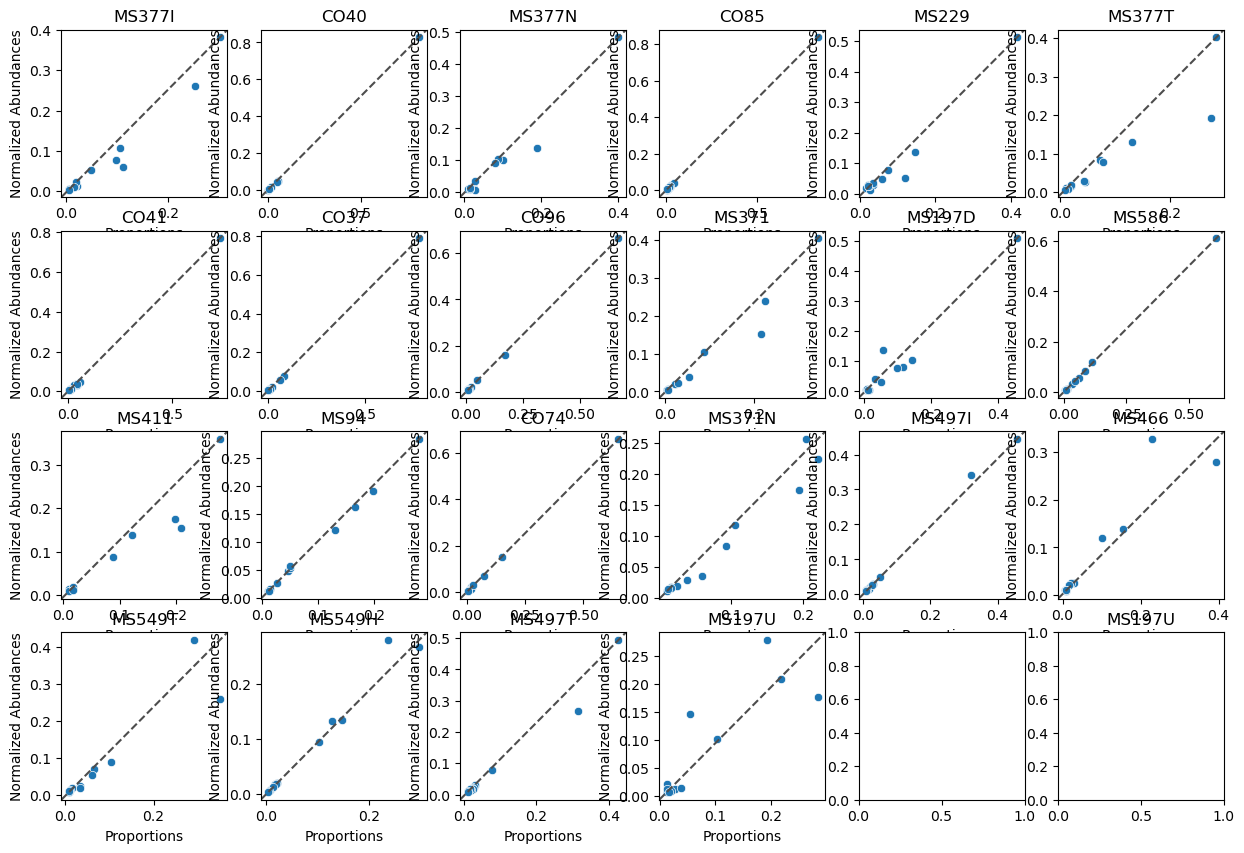

In [51]:
props = get_visium_prop("all", "cellranger", sample_meta, measure="props")
abunds = get_visium_prop("all", "cellranger", sample_meta, measure="abunds")
fig, axs = plt.subplots(4, 6, figsize=(15, 10))
axs = axs.flatten()
for i, sample_id in enumerate(os.listdir(path_deconv / "cellranger")):
    sns.scatterplot(x=props.loc[props.sample_id==sample_id].vm, y=abunds.loc[abunds.sample_id==sample_id].vm, ax=axs[i])
    axs[i].plot([0, 1], [0, 1], transform=axs[i].transAxes, ls="--", c=".3")
    axs[i].set_xlabel("Proportions")
    axs[i].set_ylabel("Normalized Abundances")
    axs[i].set_title(sample_id)
    plt.title(sample_id)

In [ ]:
visium_prop = {method: {model_call: get_visium_prop(model_call, method, sample_meta, "abunds") for model_call in ["all", "condition", "lesion_type"]} for method in ["cellbender", "cellranger"]}

In [ ]:
samples_oi = set(list(annotated_meta.values())[0].sample_id) & set(list(list(visium_prop.values())[0].values())[0].sample_id)
len(samples_oi)

In [ ]:
visium_prop["cellranger"]["all"]

In [ ]:
visium_prop["cellbender"]["all"]

In [ ]:
def get_correlation(model_call, method, samples_oi, group, replace_zero=0.001):
    assert group in ["cell_types", "sample_id"]
    assert model_call in ["all", "condition", "lesion_type"]
    assert method in ["cellbender", "cellranger"]

    sc_prop = annotated_meta[method]
    vis_prop = visium_prop[method][model_call]

    # only keep rows where sample_id is in samples_oi
    sc_prop = sc_prop.loc[sc_prop.sample_id.isin(samples_oi), :]
    vis_prop = vis_prop.loc[vis_prop.sample_id.isin(samples_oi), :]

    df = pd.merge(sc_prop, vis_prop, how='outer', on=['sample_id', 'cell_types'])
    df['sc'] = np.log10(df['sc'].replace({0: np.nan}))
    df['vm'] = np.log10(df['vm'].replace({0: np.nan}))
    df = df.fillna(np.log10(replace_zero))
    grouped_df = df.groupby(group)

    def pearson_corr(x):
        return x["sc"].corr(x["vm"], method="pearson")
    def spearman_corr(x):
        return x["sc"].corr(x["vm"], method="spearman")
    
    df_out = grouped_df.apply(pearson_corr).to_frame()
    df_out = df_out.rename({0: "Pearson_R"}, axis=1)
    df_out['Spearman_R'] = grouped_df.apply(spearman_corr)
    df_out["method"] = method
    df_out["model_call"] = model_call

    return df_out

In [ ]:
for group in ["cell_types", "sample_id"]:
    for metric in ["Pearson_R", "Spearman_R"]:
        df_list = []
        for model_call in ["all", "condition", "lesion_type"]:
            for method in ["cellbender", "cellranger"]:
                df_list.append(get_correlation(model_call, method, samples_oi, group=group))
        df = pd.concat(df_list)
        df["identifer"] = df["method"] + "_" + df["model_call"]
        df.reset_index(inplace=True)

        g = sns.catplot(
            data=df,
            x=group, y=metric, hue="identifer",
            kind="bar", palette="dark", alpha=.6, height=6
        )
        g.despine(left=True)
        g.legend.set_title("")
        g.set_xticklabels(rotation=90)
        g.savefig(output_path / f"barplot_{group}_{metric}.pdf")

In [ ]:
def plot_correlation(model_call, method, samples_oi, replace_zero=0.001, save_path=None):
    sc_prop = annotated_meta[method]
    vis_prop = visium_prop[method][model_call]

    # only keep rows where sample_id is in samples_oi
    sc_prop = sc_prop.loc[sc_prop.sample_id.isin(samples_oi), :]
    vis_prop = vis_prop.loc[vis_prop.sample_id.isin(samples_oi), :]

    df = pd.merge(sc_prop, vis_prop, how='outer', on=['sample_id', 'cell_types'])
    df['sc'] = np.log10(df['sc'].replace({0: np.nan}))
    df['vm'] = np.log10(df['vm'].replace({0: np.nan}))
    df = df.fillna(np.log10(replace_zero))

    # Plot corrs per cell type
    g = sns.lmplot(x='sc', y='vm', data=df, col='cell_types', col_wrap=4, height=3, facet_kws={"sharex": False, "sharey": False})
    g.map_dataframe(annotate)
    g.fig.set_facecolor('white')
    g.fig.suptitle(f'{method}_{model_call}_deconv_corr_celltype')
    g.fig.set_tight_layout(tight='pad')
    if save_path:
        g.fig.savefig(os.path.join(save_path, f'{method}_{model_call}_deconv_corr_celltype.pdf'), dpi=300)

    # Plot corrs per sample id
    g = sns.lmplot(x='sc', y='vm', data=df, col='sample_id', col_wrap=4, height=3, facet_kws={"sharex": False, "sharey": False})
    g.map_dataframe(annotate)
    g.fig.set_facecolor('white')
    g.fig.suptitle(f'{method}_{model_call}_deconv_corr_sample')
    g.fig.set_tight_layout(tight='pad')
    if save_path:
        g.fig.savefig(os.path.join(save_path, f'{method}_{model_call}_deconv_corr_sample.pdf'), dpi=300)

In [ ]:
for method in ["cellbender", "cellranger"]:
    for model_call in ["all", "condition", "lesion_type"]:
        plot_correlation(model_call, method, samples_oi, save_path=output_path)

In [ ]:
annotated_meta["cellranger"].loc[annotated_meta["cellranger"]["cell_types"]=="B_cells", :]

In [ ]:
visium_prop["cellranger"]["condition"].loc[visium_prop["cellranger"]["condition"]["cell_types"]=="B_cells", :]

In [ ]:
model_call="condition"
method="cellranger"
replace_zero=0.001
assert model_call in ["all", "condition", "lesion_type"]
assert method in ["cellbender", "cellranger"]

sc_prop = annotated_meta[method]
vis_prop = visium_prop[method][model_call]

# only keep rows where sample_id is in samples_oi
sc_prop = sc_prop.loc[sc_prop.sample_id.isin(samples_oi), :]
vis_prop = vis_prop.loc[vis_prop.sample_id.isin(samples_oi), :]

df = pd.merge(sc_prop, vis_prop, how='outer', on=['sample_id', 'cell_types'])
df['sc'] = np.log10(df['sc'].replace({0: np.nan}))
df['vm'] = np.log10(df['vm'].replace({0: np.nan}))

In [ ]:
df.loc[df.cell_types=="B_cells", :]